Acrobot and MountainCar with DQN-PER

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT,force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PROJ = "My Drive/RL"
PROJECT_PATH = join(ROOT, PROJ)

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### importing modules

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15

In [5]:
!pip install box2d-py

import gym

     |████████████████████████████████| 450kB 2.8MB/s 


In [0]:
# env = gym.make("BipedalWalker-v3")
# env = gym.make('BipedalWalkerHardcore-v2')
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
import numpy as np
import gym
from collections import deque
import random
import pickle
import time

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


## class for DQN

In [0]:
class DQN:
    
    def __init__(self, o_space, a_space, lr, units=32):
        self.a_space = a_space
        self.state_size = o_space

        self.lr = lr
        self.units = units

        # hyperparameters
        self.discount = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.batch_size = 50
        self.train_start = 1000
        self.memory = deque(maxlen=10000)

        # create main model and target model
        self.model = self.init_model()
        self.target_model = self.init_model()

        # initialize target model
        self.update_target_model()

    def init_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.units, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.a_space, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, s):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.a_space)
        else:
            q_value = self.model.predict(s)
            return np.argmax(q_value[0])

    def add_experience(self, s, a, r, s_next, terminal):
        self.memory.append((s, a, r, s_next, terminal))
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
      
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        a, r, terminal = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            a.append(mini_batch[i][1])
            r.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            if terminal[i]:
                target[i][a[i]] = r[i]
            else:
                target[i][a[i]] = r[i] + self.discount * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

In [0]:

# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('Acrobot-v1')
# env = gym.make('LunarLander-v2')

max_episodes = 300
lr=0.001

seed=0
np.random.seed(seed)
env.action_space.np_random.seed(seed)

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN(o_space, a_space, lr, 128)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    agent.decay_epsilon()
    terminal = False
    score = 0
    start = time.time()

    state = env.reset()
    state = np.reshape(state, [1, o_space])

    while not terminal:
        a = agent.get_action(state)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # save the sample <s, a, r, s'> to the replay memory and train model.
        agent.add_experience(state, a, r, s_next, terminal)
        agent.train_model()
        score += r
        state = s_next

        if terminal:

            agent.update_target_model()
            scores.append(score)
            episodes.append(num_episode)

            print("episode:", num_episode, "  score:", score, " mem:", len(agent.memory), 'epsilon: ', agent.epsilon)

end = time.time()
elapsed = end - start
print(elapsed)


episode: 1   score: -500.0  mem: 500 epsilon:  0.99
episode: 2   score: -500.0  mem: 1000 epsilon:  0.9801
episode: 3   score: -500.0  mem: 1500 epsilon:  0.9702989999999999
episode: 4   score: -500.0  mem: 2000 epsilon:  0.96059601
episode: 5   score: -500.0  mem: 2500 epsilon:  0.9509900498999999
episode: 6   score: -485.0  mem: 2986 epsilon:  0.9414801494009999
episode: 7   score: -500.0  mem: 3486 epsilon:  0.9320653479069899
episode: 8   score: -500.0  mem: 3986 epsilon:  0.92274469442792
episode: 9   score: -500.0  mem: 4486 epsilon:  0.9135172474836407
episode: 10   score: -500.0  mem: 4986 epsilon:  0.9043820750088043
episode: 11   score: -500.0  mem: 5486 epsilon:  0.8953382542587163
episode: 12   score: -500.0  mem: 5986 epsilon:  0.8863848717161291
episode: 13   score: -500.0  mem: 6486 epsilon:  0.8775210229989678
episode: 14   score: -500.0  mem: 6986 epsilon:  0.8687458127689781
episode: 15   score: -500.0  mem: 7486 epsilon:  0.8600583546412883
episode: 16   score: -500.

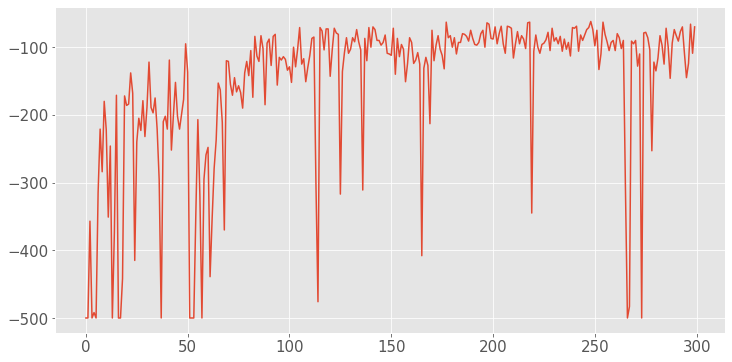

In [0]:
plt.plot(scores) # acrobot

In [0]:
env._max_episode_steps

500

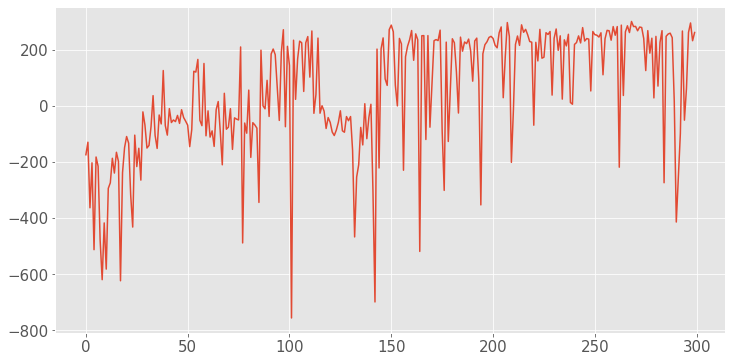

In [0]:
plt.plot(scores) # lunar lander

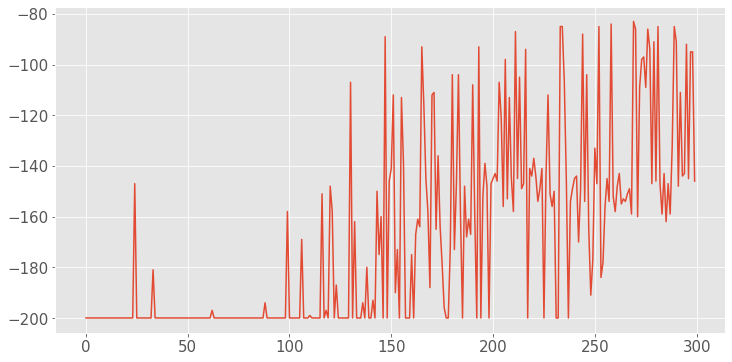

In [0]:
plt.plot(scores) # moutain car.

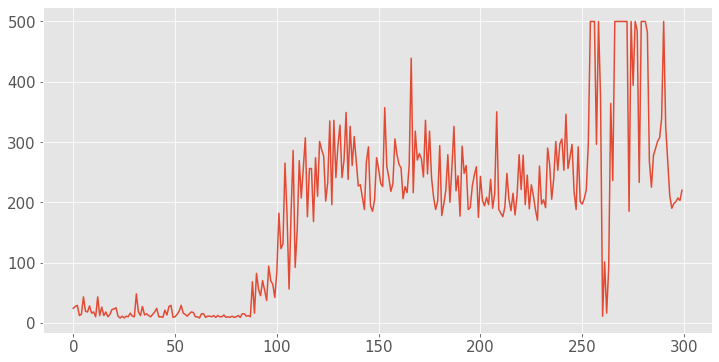

In [0]:
plt.plot(scores) # mem 20,000

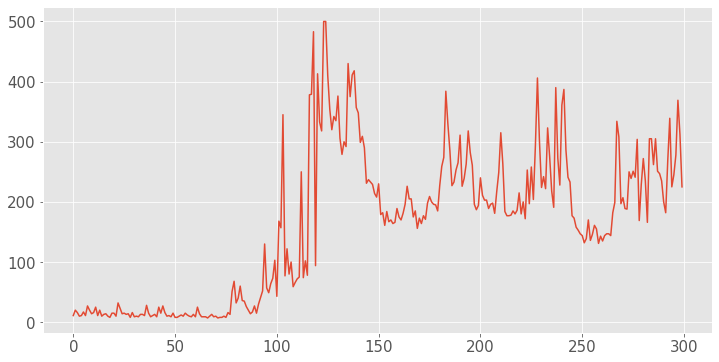

In [0]:
plt.plot(scores) # mem 200,000

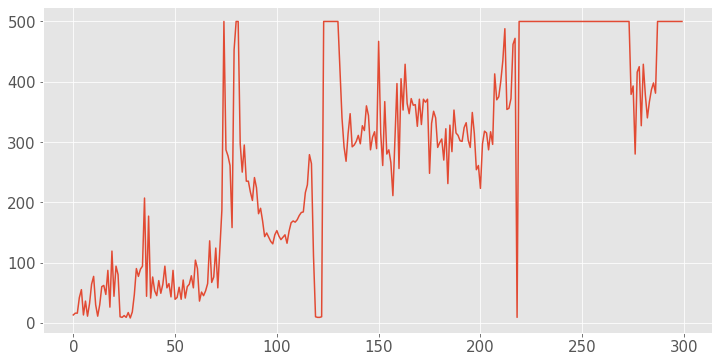

In [0]:
plt.plot(scores)  # mem 2000

# PER

In [0]:
# binary tree datastructure for PER
# from https://github.com/jaromiru/AI-blog/blob/master/SumTree.py

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [0]:
class PrioritizedER:
    
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.e = 0.001 # epsilon
        self.a = 0.6   # alpha

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append((idx, data))
        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [0]:
class DQN_PER:
    '''double DQN Agent adapted for PER'''

    def __init__(self, o_space, a_space, lr, units=32):
        self.a_space = a_space
        self.state_size = o_space

        self.lr = lr
        self.batch_size = 50
        self.units = units

        # hyperparameters
        self.discount = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.98
        self.epsilon_min = 0.01
        self.train_start = 1000
        self.memory = PrioritizedER(2000)

        # create main model and target model
        self.model = self.init_model()
        self.target_model = self.init_model()

        # initialize target model
        self.update_target_model()

    def init_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.units, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.a_space, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        model.summary()
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, s):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.a_space)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def add_experience(self, s, a, r, s_next, terminal):
        if self.epsilon == 1:
            terminal = True

        target = self.model.predict([s])
        old_val = target[0][a]
        target_val = self.target_model.predict([s_next])
        if terminal:
            target[0][a] = r
        else:
            target[0][a] = r + self.discount * (np.amax(target_val[0]))
        
        error = abs(old_val - target[0][a])

        self.memory.add(error, (s, a, r, s_next, terminal))

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        mini_batch = self.memory.sample(self.batch_size)

        errors = np.zeros(self.batch_size)
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        a, r, terminal = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][1][0]
            a.append(mini_batch[i][1][1])
            r.append(mini_batch[i][1][2])
            update_target[i] = mini_batch[i][1][3]
            terminal.append(mini_batch[i][1][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            old_val = target[i][a[i]]
            if terminal[i]:
                target[i][a[i]] = r[i]
            else:
                target[i][a[i]] = r[i] + self.discount * (np.amax(target_val[i]))
            # compute TD error for PER
            errors[i] = abs(old_val - target[i][a[i]])
        
        # update priority from TD errors.
        for i in range(self.batch_size):
            idx = mini_batch[i][0]
            self.memory.update(idx, errors[i])

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 


In [0]:
num_seeds = 5
seeds = np.arange(num_seeds)
num_episodes = 500

In [28]:
result_dict = {}

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    print(seed)

    env = gym.make('Acrobot-v1')
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n

    agent = DQN_PER(o_space, a_space, 0.001, 128)

    scores, episodes = [], []
    
    step = 0
    for num_episode in range(num_episodes):
        agent.decay_epsilon()
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, o_space])

        while not done:
            step += 1
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, o_space])

            agent.add_experience(state, action, reward, next_state, done)

            if step >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
    
                print("episode:", num_episode, "  score:", score, "  steps:",
                      step, "  epsilon:", agent.epsilon)

    result_dict[seed] = scores
        
print(result_dict)

pickle.dump( result_dict, open( PROJECT_PATH+'/acrobot-PER.pkl', "wb" ) )



0
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 387       
Total params: 17,795
Trainable params: 17,795
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
________________________

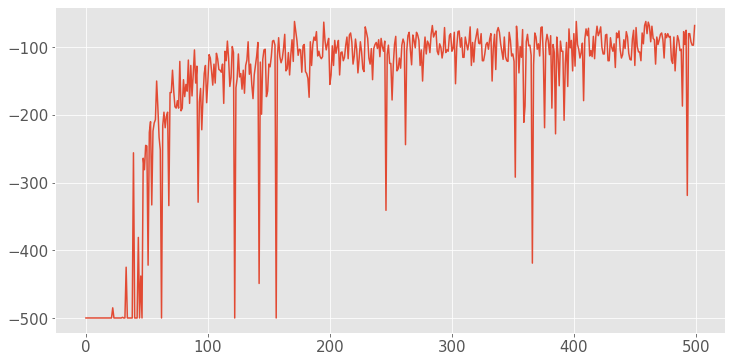

In [26]:
plt.plot(result_dict[0])  #(acrobot - PER)

In [24]:
num_seeds = 5
seeds = np.arange(num_seeds)
num_episodes = 500

result_dict = {}

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    print(seed)
    env = gym.make('MountainCar-v0')
    # env = gym.make('LunarLander-v2')
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n

    agent = DQN_PER(o_space, a_space, 0.001, 64)

    scores, episodes = [], []
    
    step = 0
    for num_episode in range(num_episodes):
        agent.decay_epsilon()
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, o_space])

        while not done:
            step += 1
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, o_space])

            agent.add_experience(state, action, reward, next_state, done)

            if step >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
    
                print("episode:", num_episode, "  score:", score, "  steps:",
                      step, "  epsilon:", agent.epsilon)

    result_dict[seed] = scores
        
print(result_dict)

pickle.dump( result_dict, open( PROJECT_PATH+'/moutain-PER-v3.pkl', "wb" ) )



0
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 195       
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
__________________________

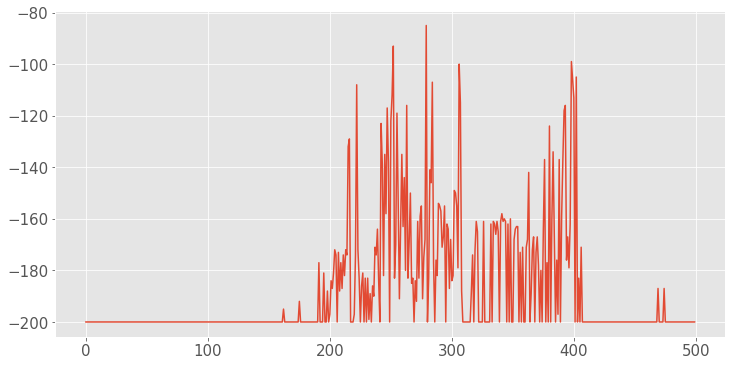

In [30]:
plt.plot(result_dict[0])  #(moutain - PER)

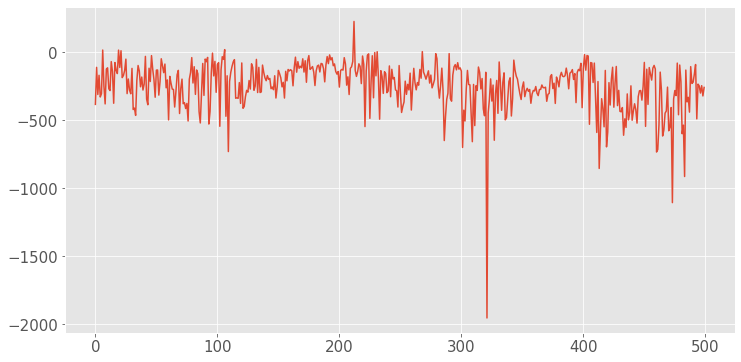

In [22]:
plt.plot(result_dict[0])  #(lunar - PER)

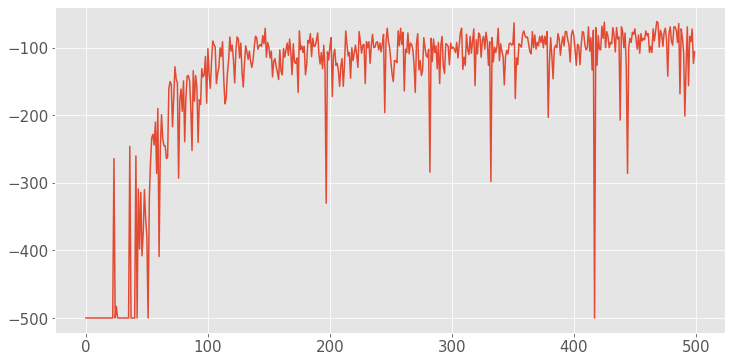

In [20]:
plt.plot(result_dict[0])  #(acrobot - PER)

In [37]:
num_seeds = 5
seeds = np.arange(num_seeds)
num_episodes = 500

result_dict = {}

env_name = 'LunarLander-v2'

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    env = gym.make(env_name)
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n

    agent = DQN_PER(o_space, a_space, 0.001, 128)

    scores, episodes = [], []
    
    step = 0
    for num_episode in range(num_episodes):
        agent.decay_epsilon()
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, o_space])

        while not done:
            step += 1
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, o_space])

            agent.add_experience(state, action, reward, next_state, done)

            if step >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
    
                print("episode:", num_episode, "  score:", score, "  steps:",
                      step, "  epsilon:", agent.epsilon)
  
    result_dict[seed] = scores
        
print(result_dict)

pickle.dump( result_dict, open( PROJECT_PATH+'/lunar-PER-3layers.pkl', "wb" ) )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 128)               1152      
_________________________________________________________________
dense_145 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_146 (Dense)            (None, 4)                 516       
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 128)               1152      
_________________________________________________________________
dense_148 (Dense)            (None, 128)               16512     
__________________________

KeyboardInterrupt: ignored

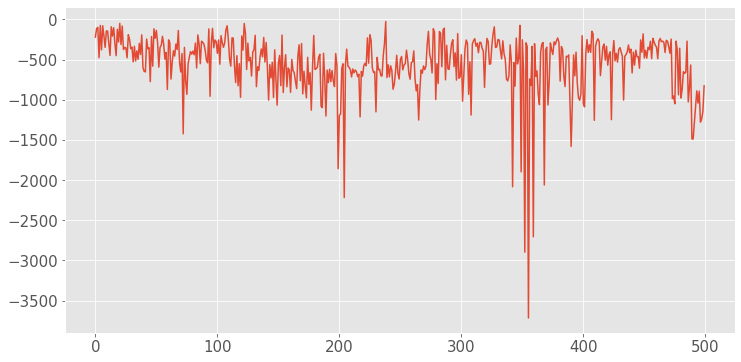

In [0]:
plt.plot(result_dict[3])

In [0]:
# pickle.dump( result_dict, open( PROJECT_PATH+'/cartpole-PER.pkl', "wb" ) )

cartpole = pickle.load( open( PROJECT_PATH+'/cartpole-PER.pkl', "rb" ) )

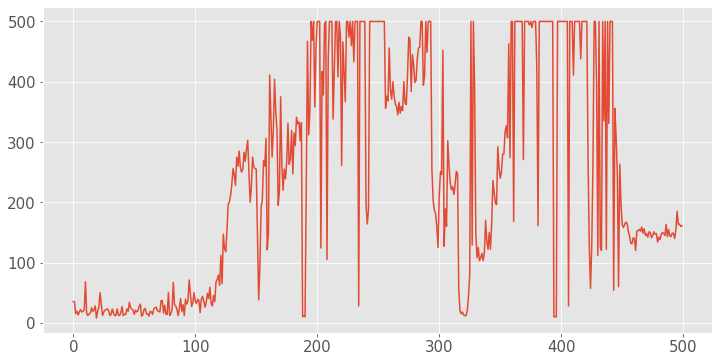

In [0]:
plt.plot(cartpole[0])